In [1]:
import scipy.io
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_fsa5
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pandas as pd


In [2]:
# Load the gradients (400x10x130 matrix)
before_aligned = scipy.io.loadmat('/home/koba/Desktop/before_aligned.mat')
before_aligned=before_aligned['before_aligned']


In [3]:
# Take the mean of control subjects for the first 3 gradients 

control_first=before_aligned[:,0,0:25]
mean_control_first=control_first.mean(axis=1)

control_second=before_aligned[:,1,0:25]
mean_control_second=control_second.mean(axis=1)

control_third=before_aligned[:,2,0:25]
mean_control_third=control_third.mean(axis=1)

In [4]:
# Load the surface mesh and labeling
surf_lh, surf_rh = load_conte69()
labeling = load_parcellation('schaefer', scale=400, join=True)

In [7]:
# Map the 400 values to size of meshes

grad1 = map_to_labels(mean_control_first, labeling, mask=labeling != 0, fill=np.nan)
grad2 = map_to_labels(mean_control_second, labeling, mask=labeling != 0, fill=np.nan)
grad3 = map_to_labels(mean_control_third, labeling, mask=labeling != 0, fill=np.nan)

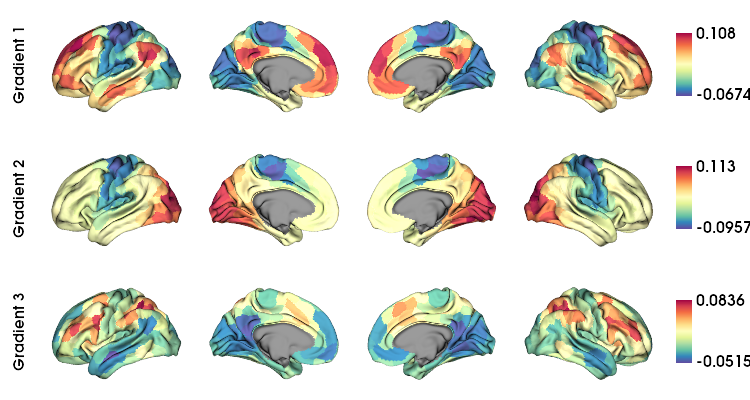

In [38]:
plot_hemispheres(surf_lh, surf_rh, array_name=[grad1, grad2, grad3],
                 size=(750, 400), zoom=1.25, color_bar=True, cmap='Spectral_r', embed_nb=True,
                 screenshot=False, filename='mean_control_first3.svg',
                 label_text=['Gradient 1', 'Gradient 2', 'Gradient 3'])


In [16]:
# Calculating C (colorcodes for the nodes)
norm_1 = mpl.colors.Normalize(vmin=mean_control_first.min(), vmax=mean_control_first.max())
cmap_1 = cm.Reds
map_1  = cm.ScalarMappable(norm=norm_1, cmap=cmap_1)

norm_2 = mpl.colors.Normalize(vmin=mean_control_second.min(), vmax=mean_control_second.max())
cmap_2 = cm.Greens
map_2  = cm.ScalarMappable(norm=norm_2, cmap=cmap_2)

norm_3 = mpl.colors.Normalize(vmin=mean_control_third.max(), vmax=mean_control_third.min() )
cmap_3 = cm.Blues
map_3  = cm.ScalarMappable(norm=norm_3, cmap=cmap_3)

c = np.ones(map_1.to_rgba(mean_control_first).shape)

a = mean_control_second.copy()
a = a - a.min() 
a = a / a.max()
c[:,1] = a

a = mean_control_third.copy()
a = a - a.min() 
a = a / a.max()
c[:,2] = a

a = mean_control_first.copy()
a = a - a.min() 
a = a / a.max()
c[:,0] = a
c[:,1] = c[:,1] * ((a - 1) * -1)
c[:,2] = c[:,2] * ((a - 1) * -1)

#d = np.ones(map_1.to_rgba(grad1).shape) 
#d[:, 0:3] = np.array(c_long).transpose()

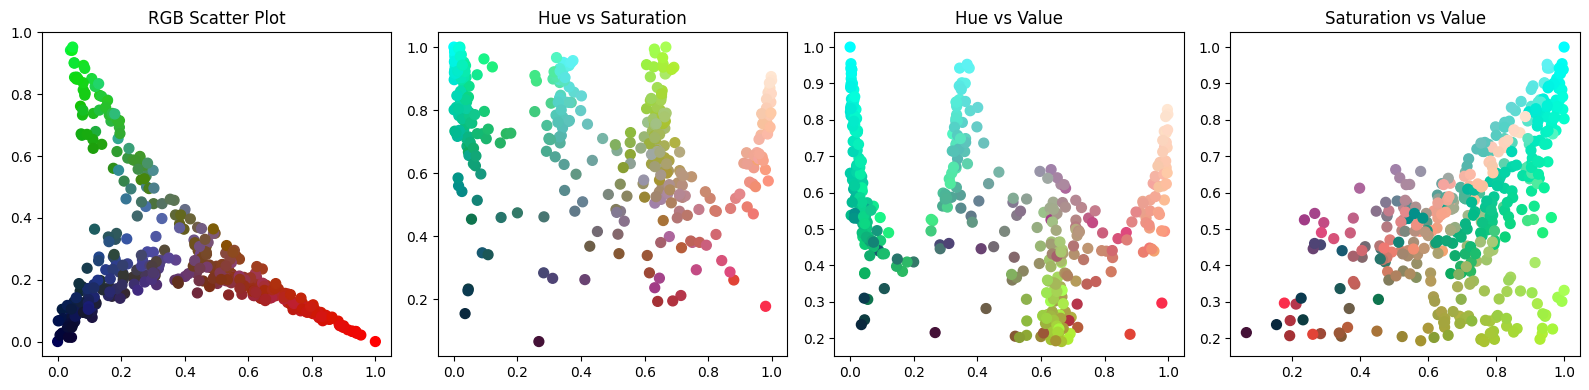

In [17]:
# Calculate hue, luminance, saturation etc... from C matrix. Hue values are the most indicative of the gradient values

from matplotlib.colors import rgb_to_hsv

def rgb_row_to_grayscale(rgb_row):
    return 0.299 * rgb_row[0] + 0.587 * rgb_row[1] + 0.114 * rgb_row[2]

# Example RGB matrix
rgb_matrix = c[:,0:3]  # Replace with your actual RGB matrix

# Convert each RGB row to grayscale
grayscale_values = np.apply_along_axis(rgb_row_to_grayscale, axis=1, arr=rgb_matrix)
luminance_values = np.dot(rgb_matrix, [0.299, 0.587, 0.114])


# Assuming 'rgb_matrix' is your 400x3 matrix
# Replace 'rgb_matrix' with the actual name of your matrix
rgb_matrix = c[:,0:3]  # Replace with your actual RGB matrix

# Convert RGB to HSV
hsv_matrix = rgb_to_hsv(rgb_matrix)

# Extract Hue, Saturation, and Value components
hue_values = hsv_matrix[:, 0]
saturation_values = hsv_matrix[:, 1]
value_values = hsv_matrix[:, 2]

# Example plotting (replace with your specific use case)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original RGB scatter plot
axes[0].scatter(rgb_matrix[:, 0], rgb_matrix[:, 1], c=rgb_matrix , s=50)
axes[0].set_title('RGB Scatter Plot')

# HSV scatter plots
axes[1].scatter(hue_values, saturation_values, c=hsv_matrix / np.max(hsv_matrix, axis=0), s=50)
axes[1].set_title('Hue vs Saturation')

axes[2].scatter(hue_values, value_values, c=hsv_matrix / np.max(hsv_matrix, axis=0), s=50)
axes[2].set_title('Hue vs Value')

axes[3].scatter(saturation_values, value_values, c=hsv_matrix / np.max(hsv_matrix, axis=0), s=50)
axes[3].set_title('Saturation vs Value')

plt.tight_layout()
plt.show()

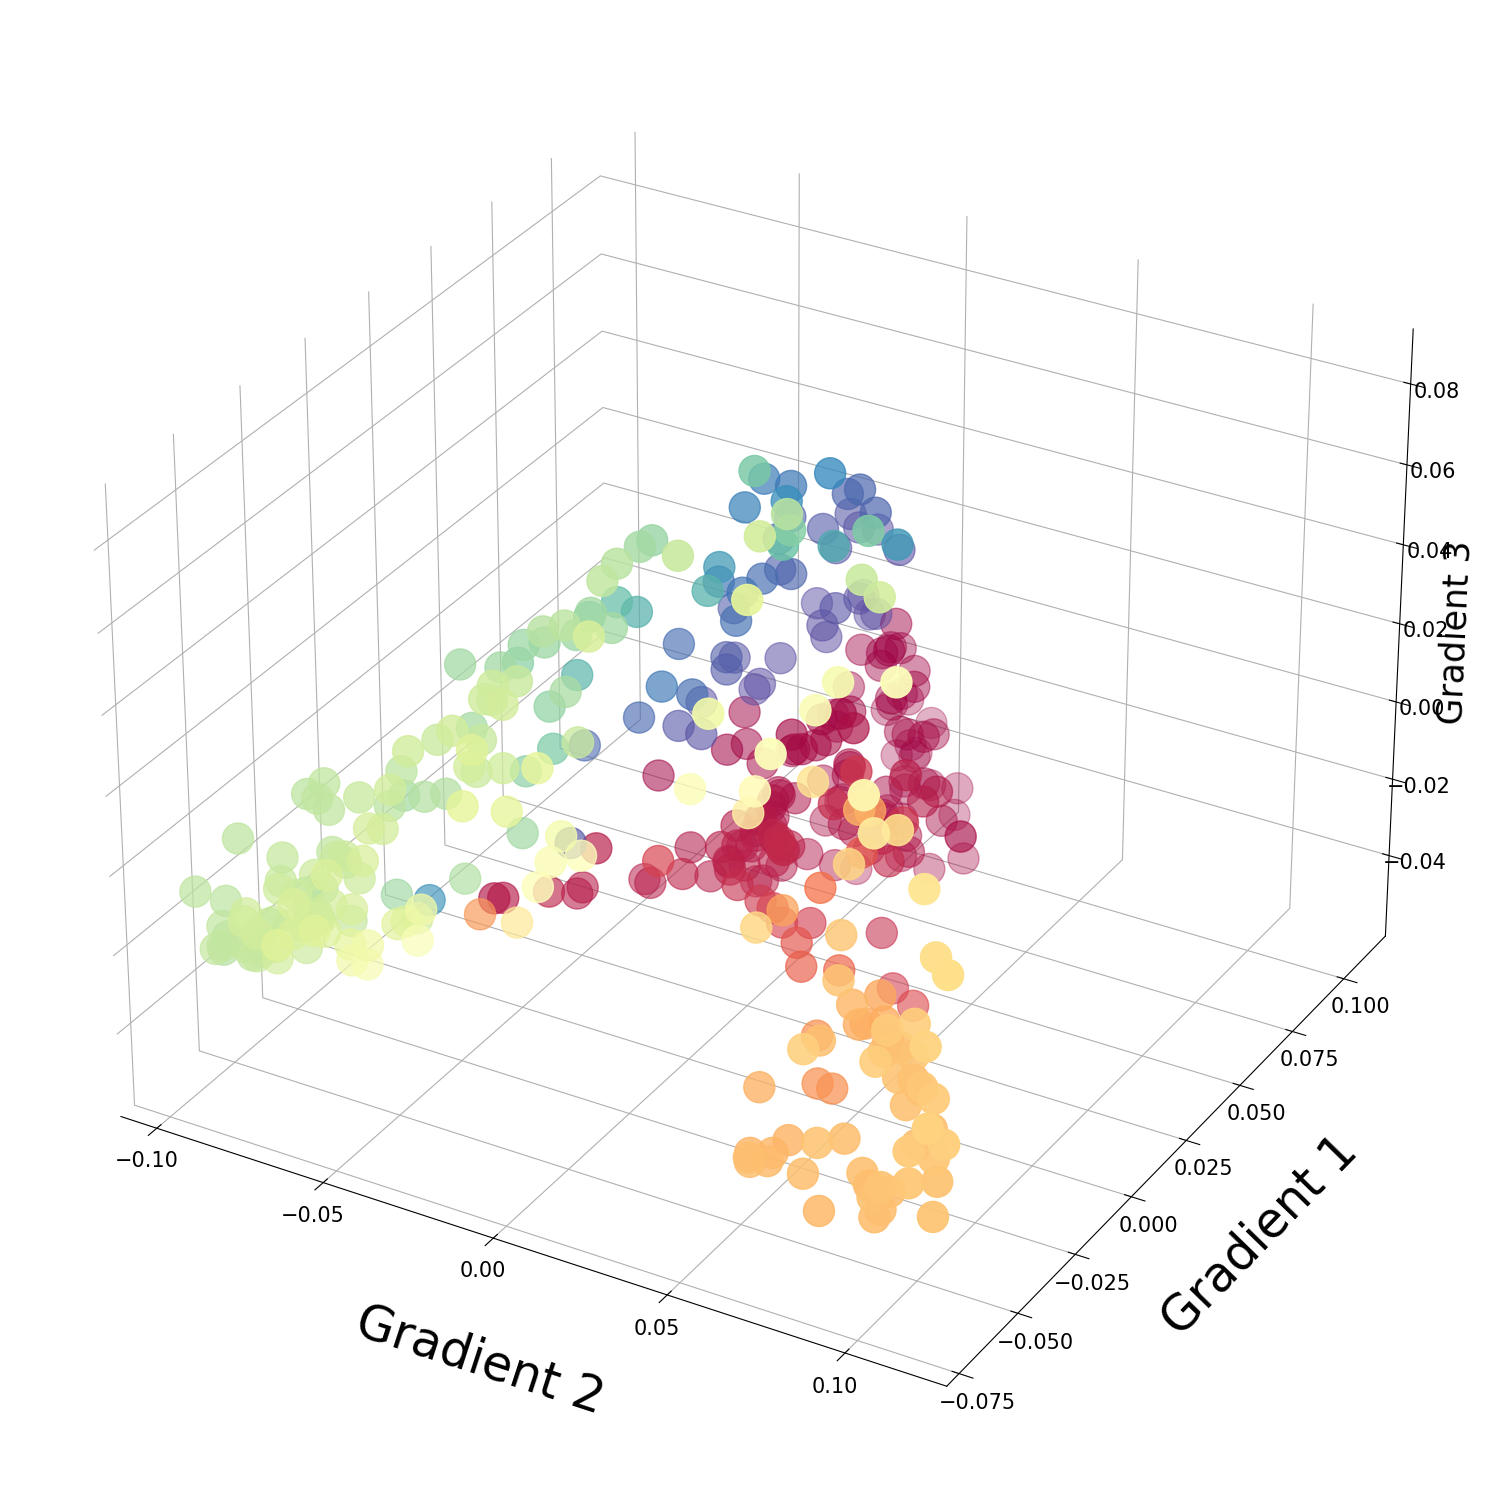

In [29]:
# Draw th 3D scatter


figure = plt.figure(figsize=(15,15), facecolor='w')
ax     = figure.add_subplot(projection='3d') 

ax.patch.set_facecolor('white')
#ax.grid(False)
# cc = gd1_2_pred + 30*gd1_2_distance.min(axis=1)
ax.scatter(mean_control_second,mean_control_first, mean_control_third, 
           c=hue_values,
            cmap=plt.colormaps['Spectral'],
           s = 500,
           )

ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


yLabel = ax.set_ylabel('\nGradient 1', linespacing=3.1, fontsize=35)
xLabel = ax.set_xlabel('\nGradient 2', linespacing=3.2, fontsize=35)
zLabel = ax.set_zlabel('Gradient 3', fontsize=25)

ax.dist = 10
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.show()

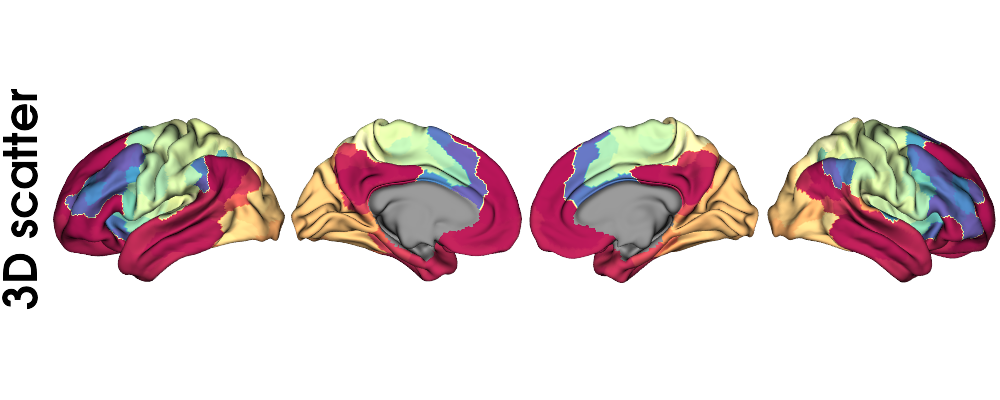

In [35]:
hue = map_to_labels(hue_values, labeling, mask=labeling != 0, fill=np.nan)
plot_hemispheres(surf_lh, surf_rh, array_name=hue,
                 size=(1000, 400), zoom=1.25, color_bar=False,cmap='Spectral',
                 embed_nb=True, screenshot=False, filename='3d_scatter_on_brain.png',
                 label_text=['3D scatter'])

In [107]:
# Load the lambdas
before_lambda = scipy.io.loadmat('/home/koba/Desktop/before_lambda.mat')
before_lambda=before_lambda['before_lambda']
before_lambda=pd.DataFrame(before_lambda.transpose())
before_lambda=before_lambda.iloc[:,0:10]

In [109]:
before_lambda

,0,1,2,3,4,5,6,7,8,9,Group
0,0.150028,0.123388,0.101664,0.077274,0.072909,0.056868,0.048649,0.044327,0.041145,0.039365,Control
1,0.162370,0.131648,0.103475,0.079865,0.069486,0.053240,0.050556,0.045886,0.042888,0.037924,Control
2,0.186660,0.122643,0.107276,0.081534,0.075021,0.053125,0.051563,0.048978,0.038300,0.033723,Control
3,0.189752,0.164667,0.114936,0.074108,0.053179,0.050517,0.044239,0.040359,0.037775,0.035362,Control
4,0.173601,0.137882,0.099238,0.071277,0.065735,0.061486,0.051126,0.047498,0.039110,0.037004,Control
...,...,...,...,...,...,...,...,...,...,...,...
125,0.180860,0.147421,0.103437,0.078533,0.066079,0.054243,0.046540,0.042648,0.040140,0.035914,Stroke
126,0.168113,0.120760,0.108842,0.091895,0.068169,0.052208,0.047669,0.041810,0.037932,0.035074,Stroke
127,0.172782,0.149149,0.111358,0.074326,0.058649,0.052485,0.047053,0.042444,0.039497,0.036049,Stroke
128,0.146664,0.138605,0.115031,0.069503,0.064908,0.055579,0.048602,0.047981,0.039709,0.038806,Stroke


In [98]:
import seaborn as sns 

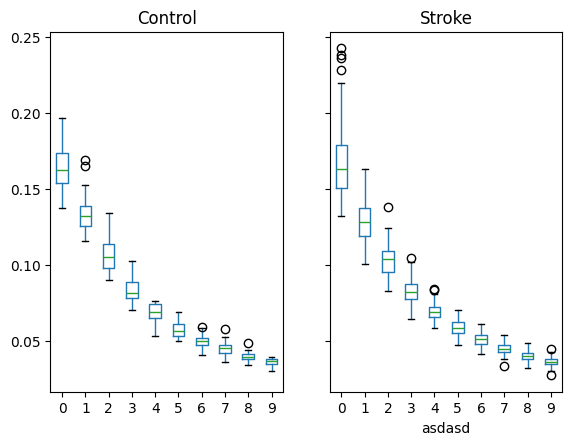

In [149]:
before_lambda['Group'] = np.where(before_lambda.index < 26, 'Control', 'Stroke')
# Group the DataFrame by the 'Group' column
grouped_df = before_lambda.groupby('Group')

# Create a box plot with mean markers
ax = grouped_df.boxplot( grid=False)
# Set plot title
# plt.title('Scaled Eigenvalues of the gradients for  Control and Stroke')
plt.tight_layout
# Show the plot
plt.show()

In [ ]:
# Clustering

import sklearn 
import matplotlib.pyplot as plt
cmap_name_gd1_2 = 'jet' 
cmap_name_gd1 = 'viridis_r'


# Cluster each region (point in surface) corresponds to gradient splitting
from sklearn.cluster import KMeans
grad = [mean_control_first,mean_control_second,mean_control_third]
grad_array = np.array(grad)
grad_array = grad_array[:,~np.isnan(grad_array).any(axis=0)] # Discard nan values
gd1_pred = KMeans(n_clusters=2, random_state=0).fit_predict(grad_array.T) 
gd1_2_pred = KMeans(n_clusters=4, random_state=0).fit_predict(grad_array.T)
gd1_plot, gd1_2_plot = [], []
i = 0
for g in grad[0]:
    if np.isnan(g):
        gd1_plot.append(np.nan)
        gd1_2_plot.append(np.nan)
    else:
        gd1_plot.append(gd1_pred[i])
        gd1_2_plot.append(gd1_2_pred[i])
        i += 1
gd1_plot, gd1_2_plot = np.array(gd1_plot), np.array(gd1_2_plot)  

fig, ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.08,
                bottom=0.08, 
                right=0.82, 
                top=0.82)
cm = plt.cm.get_cmap(cmap_name_gd1_2)
sc_gds = plt.scatter(grad_array[1,:], grad_array[0,:], c=gd1_2_pred, cmap=cm, s=2)
#sc_gds = plt.scatter(grad[1], grad[0], c=grad[0], cmap=cm)
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
ax.set_xlabel("Gradient 2"), ax.set_ylabel("Gradient 1")
#ax.set_xticks([-30,-15,0,15,30]), ax.set_xticklabels(["-30","-15","0","15","30"])
#ax.set_yticks([-30,0,30,60]), ax.set_yticklabels(["-30","0","30","60"])
#ax.set_xlim([-33,38]), ax.set_ylim([-40,62])
#fig.colorbar(sc_gds, pad=0.01)

left, bottom, width, height = [0.08, 0.84, 0.74, 0.14]
inset = fig.add_axes([left, bottom, width, height])
inset.spines['right'].set_visible(False), inset.spines['top'].set_visible(False), inset.spines['left'].set_visible(False)
inset.set_xticks([]), inset.set_xticklabels([])
inset.set_yticks([]), inset.set_yticklabels([])
inset.set_xlim([-33,38])
inset.hist(grad[1], bins=25, density=True, color='black', alpha=.6)

left, bottom, width, height = [0.84, 0.08, 0.14, 0.74]
inset = fig.add_axes([left, bottom, width, height])
inset.spines['right'].set_visible(False), inset.spines['top'].set_visible(False), inset.spines['bottom'].set_visible(False)
inset.set_xticks([]), inset.set_xticklabels([])
inset.set_yticks([]), inset.set_yticklabels([])
inset.set_ylim([-40,62])
inset.hist(np.where(gd1_plot==1, grad[0], np.nan),
    bins=25, density=True, orientation='horizontal', color='indigo')
inset.hist(np.where(gd1_plot==0, grad[0], np.nan),
    bins=25, density=True, orientation='horizontal', color='gold')




plot_hemispheres(surf_lh, surf_rh, array_name=gd1_2_plot, 
    color_bar=False, size=(900, 600), cmap=cmap_name_gd1_2, zoom=1.4, transparent_bg=False,
    interactive=False, layout_style='grid')
